<a href="https://colab.research.google.com/github/XiangxiangXu/NFL/blob/main/mm_cosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import numpy as np

def array_download(fname, array):
    np.save(fname, array)
    files.download(fname)
    return 0


Multimodal Learning Problem on a raised cosine distribution.

$$\begin{align*}
   P_{X_1, X_2}(x_1, x_2) = \frac14 \cdot\left[ 1 + \cos(2\pi(x_1 - x_2))\right]
\end{align*}
$$ $$
\begin{align*}
  P_{Y|X_1, X_2}(y|x_1, x_2) = \frac12 + \frac{y}{4} \cdot \left[
\cos(\pi x_1) + \cos(\pi x_2)  +  \cos(\pi(x_1 + x_2))
\right]
\end{align*}
$$

Set GPU.

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
import torch

In [ ]:
import numpy as np
from scipy.stats import cosine


def modshift(t):
    # shift t to interval [-1, 1] by some 2 * n
    return np.divmod(t + 1, 2)[1] - 1



In [ ]:
# number of samples
nSamples_train = 50000
nSamples_test = 10000
nSamples = nSamples_train + nSamples_test


## Parameters for Training
# batch size
batchsize = 256

# number of epochs
nEpochs = 100

dim = 2

Generate $X \sim p_X(x) = \frac12 (1 + \cos(2\pi x)), \quad x \in [-1, 1]$.

In [ ]:
lambda cos_rv = len: cosine.rvs(size=(len)) / np.pi    # 1/2 * (1_cos(pi x))

def cos_rv2(len):
    # generate x of length = len, such that
    W_n = (cosine.rvs(size=len) / np.pi - 1)/2 # W_p in [-1, 0], raised cosine
    W_p = (cosine.rvs(size=len) / np.pi + 1)/2 # W_n in [0, 1], raised cosine
    s = np.random.binomial(1, 1/2, len) # s: switch
    return s * W_p + (1-s) * W_n


In [ ]:
X1 = 2 * np.random.rand(nSamples) - 1  # x ~ Unif[-1, 1]
X2 = modshift(X1 + cos_rv2(nSamples))

cos_pi = lambda x: np.cos(np.pi * x)
p_cond = lambda x1, x2:  1/2 + 1/4 * (cos_pi(x1) + cos_pi(x2) + cos_pi(x1 + x2))
p_cond_bi = lambda x1, x2:  1/2 + 1/4 * (cos_pi(x1) + cos_pi(x2))

Y = np.random.rand(nSamples) < p_cond(X1, X2)
Y = Y.astype(int)
# for convenience, we map all y = -1 to y = 0.

(array([1907., 2057., 2111., 1922., 1987., 1997., 2029., 2071., 1974.,
        2009., 1986., 2001., 2017., 2074., 2023., 1958., 1990., 1973.,
        2011., 1999., 1936., 1963., 1990., 2060., 2017., 1980., 1973.,
        1958., 1964., 2063.]),
 array([-9.99975568e-01, -9.33309894e-01, -8.66644220e-01, -7.99978546e-01,
        -7.33312872e-01, -6.66647198e-01, -5.99981524e-01, -5.33315850e-01,
        -4.66650176e-01, -3.99984502e-01, -3.33318828e-01, -2.66653154e-01,
        -1.99987480e-01, -1.33321806e-01, -6.66561322e-02,  9.54179653e-06,
         6.66752158e-02,  1.33340890e-01,  2.00006564e-01,  2.66672238e-01,
         3.33337912e-01,  4.00003586e-01,  4.66669260e-01,  5.33334934e-01,
         6.00000608e-01,  6.66666282e-01,  7.33331956e-01,  7.99997630e-01,
         8.66663304e-01,  9.33328978e-01,  9.99994652e-01]),
 <BarContainer object of 30 artists>)

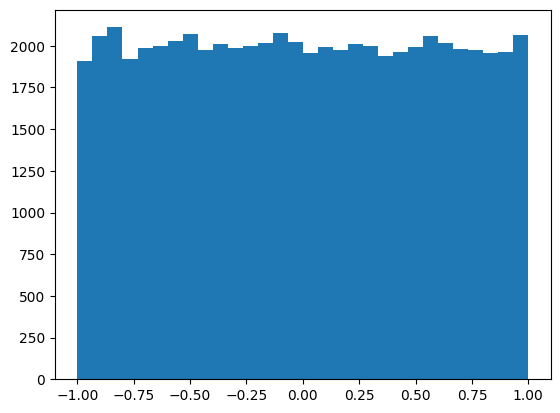

In [ ]:
from matplotlib import pyplot as plt
plt.hist(X1, 30)

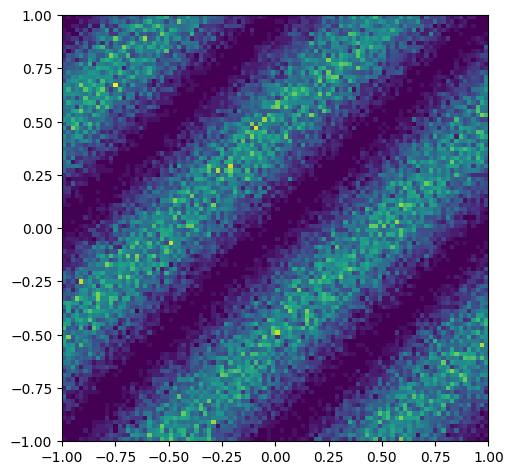

In [ ]:
plt.hist2d(X1, X2, 100)#, range=np.array([(-1, 1), (-1, 1)]))

#plt.xlim(-1, 1)
#plt.ylim(-1, 1)
#plt.axis('equal')
plt.tight_layout()
plt.axis([-1, 1, -1, 1])
plt.gca().set_aspect('equal', adjustable='box')

Define Dataloaders.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F

X1t = torch.tensor(X1, dtype=torch.float32)
X2t = torch.tensor(X2, dtype=torch.float32)
Yt = torch.tensor(Y)
y_card = 2
Yt = F.one_hot(Yt, y_card).type(torch.FloatTensor)
# dataloder for training

get_train = lambda x: x[:nSamples_train]
get_test = lambda x: x[nSamples_train:]


X1t_train, X2t_train, Yt_train = map(get_train, [X1t, X2t, Yt])

# test data
X1_test, X2_test, Y_test = map(get_test, [X1, X2, Y])
X1t_test, X2t_test, Yt_test = map(get_test, [X1t, X2t, Yt])


ds = TensorDataset(X1t_train, X2t_train, Yt_train)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)



### Define Neural Feature Extractors

In [ ]:
from torch import nn, optim

# f g module with two parts (fb, gb) & (f, g)
class fg_nn2(nn.Module): # with two parts
    def __init__(self, fb_net, gb_net, f_net, g_net):
        super().__init__()

        self.fb_net = fb_net
        self.gb_net = gb_net
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        fb = self.fb_net(x)
        gb = self.gb_net(y)
        f = self.f_net(x)
        g = self.g_net(y)
        return fb, gb, f, g

    def get_fb(self, x):
        fb = self.fb_net(x)
        return fb

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_gb(self, y):
        gb = self.gb_net(y)
        return gb

    def get_g(self, y):
        g = self.g_net(y)
        return g

centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (nagative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(f[:, :i+1], g[:, :i+1])
         for i in range(dim0, f_dim)]))
    return neg_h_nest

def neg_hscore2(fb, gb, f, g):
    """
    compute the (nagative) H-score with two parts

    from dim 0
    """
    res = neg_hscore(fb, gb)
    res += neg_hscore(torch.cat([fb, f], axis = 1), torch.cat([gb, g], axis = 1))
    return res

In [ ]:

class mlp(nn.Module):
    def __init__(self, dim_list, activation = F.relu):
        super().__init__()
        self.fc_list = nn.ModuleList([nn.Linear(dim_list[i], dim_list[i+1]) for i in range(len(dim_list) - 1)])
        self.activation = activation

    def forward(self, x):
        num_layers = len(self.fc_list)
        for i in range(num_layers):
            x = self.fc_list[i](x)
            if i != num_layers - 1: # activate except for the last layer
                x = self.activation(x)
        return x

class mlp_parallel(nn.Module):
    def __init__(self, dim_list, m = 1, activation = F.relu):
        super().__init__()
        self.mlp_list = nn.ModuleList([mlp(dim_list, activation) for i in range(m)])

    def forward(self, x):
        f = torch.cat([mlp_(x) for mlp_ in self.mlp_list], axis = -1)
        return f

class mlp_sum(nn.Module): # return mlp1 + mpl2
    def __init__(self, dim_list1, dim_list2,  activation = F.relu):
        super().__init__()
        self.mlp_list = nn.ModuleList([mlp(dim_list1, activation), mlp(dim_list2, activation)])

    def get_f1(self, x1):
        return self.mlp_list[0](x1)

    def get_f2(self, x2):
        return self.mlp_list[1](x2)

    def forward(self, x):
        x1, x2 = x
        f1 = self.get_f1(x1)
        f2 = self.get_f2(x2)
        return f1 + f2


class mlp_2in(nn.Module): # return mlp with concatenated input
    def __init__(self, dim_list,  activation = F.relu):
        super().__init__()
        self.mlp_ = mlp(dim_list, activation)

    def forward(self, x):
        x1, x2 = x
        f = self.mlp_(torch.cat(x, axis = -1))
        return f

kb = 1
k = 1
# x = [x1, x2]
fb_net = mlp_sum([1, 32, 32, kb], [1, 32, 32, kb], activation = F.softplus)
gb_net = mlp([2, kb]) # linear layer

f_net = mlp_2in([2, 32, 32, k], activation = F.softplus)
g_net = mlp([2, k]) # linear layer


model = fg_nn2(fb_net, gb_net, f_net, g_net)
model.to(device)
opt = optim.Adam(model.parameters()) # optim.RMSprop(model.parameters(), lr = 1e-3) # or Adam

In [ ]:
for epoch in range(nEpochs):
    for x1, x2, y in dl:
        fb_, gb_, f_, g_ = model([x1.reshape(-1, 1).to(device), x2.reshape(-1, 1).to(device)], y.to(device))
        loss = neg_hscore2(fb_, gb_, f_, g_)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % 10 == 0:
        print('epoch:', epoch+1, '/', nEpochs)# 'training neg_h_score =', loss)


epoch: 1 / 100
epoch: 11 / 100
epoch: 21 / 100
epoch: 31 / 100
epoch: 41 / 100
epoch: 51 / 100
epoch: 61 / 100
epoch: 71 / 100
epoch: 81 / 100
epoch: 91 / 100


In [ ]:
detach = lambda x: x.cpu().detach().numpy()
norm = lambda x: np.sqrt(np.mean(x**2))

# get features on the training set
fb_train = detach(model.get_fb([X1t_train.reshape(-1, 1), X2t_train.reshape(-1, 1)]))
f_train = detach(model.get_f([X1t_train.reshape(-1, 1), X2t_train.reshape(-1, 1)]))

norm_fb = norm(fb_train)
norm_f = norm(f_train)

gb_train =  detach(model.get_gb(torch.eye(y_card)))
g_train =  detach(model.get_g(torch.eye(y_card)))
#norm_gb = norm(gb_train)
#norm_g = norm(g_train)
#g_train = detach(model.get_g(Yt_train.reshape(-1, 1)))


X1t_grid = torch.linspace(-1, 1, steps=100)#.reshape(-1, 1)
X2t_grid = X1t_grid #torch.linspace(-1, 1, steps=1000).reshape(-1, 1)
X1_grid = detach(X1t_grid).reshape(-1)
X2_grid = detach(X2t_grid).reshape(-1)


# f_grid = detach(model.get_f(Xt_grid))

def pred(self, f, g, py):
    pygx = py * (1 + f @ g.T)
    y_pred = torch.argmax(pygx, 1)
    return pygx, y_pred

col = lambda x: x.reshape(-1, 1)

In [ ]:
#dx = .001
X1t_grid2, X2t_grid2 = torch.meshgrid(X1t_grid, X2t_grid, indexing='xy')
X1_grid2, X2_grid2 = map(detach, [X1t_grid2, X2t_grid2])
#x2, x1 = np.mgrid[-1:1:dx, -1:1:dx]#[X2_grid, X1_grid]
#x1 =

In [ ]:
fb_grid2 = np.zeros(X1t_grid2.shape)
f_grid2 = np.zeros(X1t_grid2.shape)
for i in range(X1t_grid2.shape[0]):
    fb_grid2[i] = detach(model.get_fb([X1t_grid2[i].reshape(-1, 1), X2t_grid2[i].reshape(-1, 1)])).reshape(-1)
    f_grid2[i] = detach(model.get_f([X1t_grid2[i].reshape(-1, 1), X2t_grid2[i].reshape(-1, 1)])).reshape(-1)


fb_plot = fb_grid2 / norm_fb
f_plot = f_grid2 / norm_f

fb_grid_gt = cos_pi(X1_grid2) + cos_pi(X2_grid2)# + cos_pi(X1 + X2)
f_grid_gt = np.sqrt(2) * cos_pi(X1_grid2 + X2_grid2)

fb_plot *= np.sign(np.sum(fb_plot * fb_grid_gt))
f_plot *= np.sign(np.sum(f_plot * f_grid_gt))

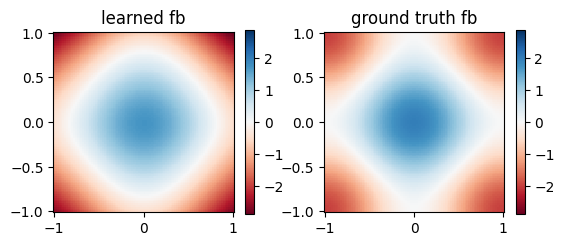

In [ ]:
fbmax = np.max(np.abs(fb_plot))

fig, axs = plt.subplots(1, 2)

ax = axs[0]
c = ax.pcolormesh(X1_grid2, X2_grid2, fb_plot, cmap='RdBu', vmin=-fbmax, vmax=fbmax)
ax.set_title('learned fb')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

ax = axs[1]
c = ax.pcolormesh(X1_grid2, X2_grid2, fb_grid_gt, cmap='RdBu', vmin=-fbmax, vmax=fbmax)
ax.set_title('ground truth fb')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)


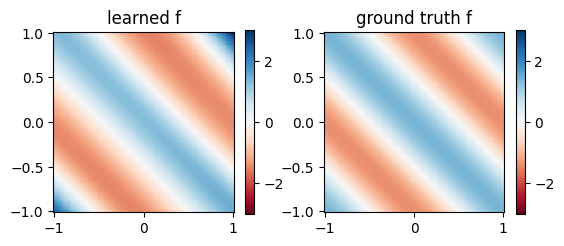

In [ ]:
fmax = np.max(np.abs(f_plot))


fig, axs = plt.subplots(1, 2)

ax = axs[0]
c = ax.pcolormesh(X1_grid2, X2_grid2, f_plot, cmap='RdBu', vmin=-fmax, vmax=fmax)
ax.set_title('learned f')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

ax = axs[1]
c = ax.pcolormesh(X1_grid2, X2_grid2, f_grid_gt, cmap='RdBu', vmin=-fmax, vmax=fmax)
ax.set_title('ground truth f')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

#plt.pcolormesh(X1_grid2, X2_grid2, f_grid2, cmap='RdBu', vmin=-fmax, vmax=fmax)
#plt.colorbar()

In [ ]:
p_cond_learnd = 1/2 *( 1 + fb_grid2 * gb_train[1] + f_grid2 * g_train[1]) # works only for kb > 1
p_cond_gt = p_cond(X1_grid2, X2_grid2)

p_cond_bi_learnd = 1/2 *( 1 + fb_grid2 * gb_train[1]) # works only for kb > 1
p_cond_bi_gt = p_cond_bi(X1_grid2, X2_grid2)

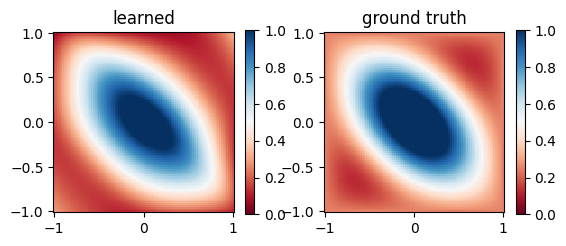

In [ ]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
c = ax.pcolormesh(X1_grid2, X2_grid2, p_cond_learnd, cmap='RdBu', vmin=0, vmax=1)
ax.set_title('learned')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

ax = axs[1]
c = ax.pcolormesh(X1_grid2, X2_grid2, p_cond_gt, cmap='RdBu', vmin=0, vmax=1)
ax.set_title('ground truth')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

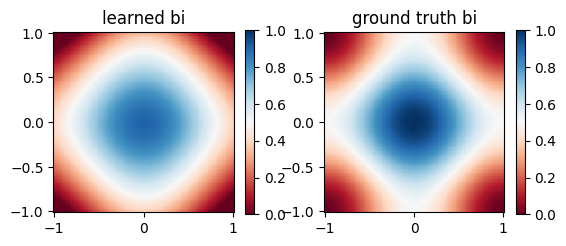

In [ ]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
c = ax.pcolormesh(X1_grid2, X2_grid2, p_cond_bi_learnd, cmap='RdBu', vmin=0, vmax=1)
ax.set_title('learned bi')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

ax = axs[1]
c = ax.pcolormesh(X1_grid2, X2_grid2, p_cond_bi_gt, cmap='RdBu', vmin=0, vmax=1)
ax.set_title('ground truth bi')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, shrink=.5)

In [ ]:
# get features on the testing set
# f_test = model.get_f(Xt_test.reshape(-1, 1)).detach().numpy()
# g_test = model.get_g(Yt_test.reshape(-1, 1)).detach().numpy()

# # compute stand deviations for each dimension
# std_f = np.zeros(dim)
# std_g = np.zeros(dim)
# mu_f = np.zeros(dim)
# mu_g = np.zeros(dim)
# for i in range(dim):
#     mu_f[i] = np.mean(f_test[:, i])
#     std_f[i] = np.std(f_test[:, i])
#     mu_g[i] = np.mean(g_test[:, i])
#     std_g[i] = np.std(g_test[:, i])

Train models to compute $\tau_{X_1}(f^{(2)}), \tau_{X_2}(f^{(1)})$.


In [ ]:
model_tau1 = mlp([kb, 32, 32, kb], activation = F.softplus)
# use x1 to predict fb2(x2)
model_tau1.to(device)
opt_tau1 = optim.Adam(model_tau1.parameters())
loss = nn.MSELoss()

for epoch in range(nEpochs):
    for x1, x2, _ in dl:
        fb2_pred = model_tau1(col(x1).to(device))
        #
        with torch.no_grad():
            fb2_target = fb_net.get_f2(col(x2).to(device))
        output = loss(fb2_pred, fb2_target)
        output.backward()
        opt_tau1.step()
        opt_tau1.zero_grad()
    if epoch % 10 == 0:
        print("Epoch " + str(epoch) + '/' + str(nEpochs))
        print(output)

Epoch 0/100
tensor(0.3529, grad_fn=<MseLossBackward0>)
Epoch 10/100
tensor(0.2885, grad_fn=<MseLossBackward0>)
Epoch 20/100
tensor(0.3019, grad_fn=<MseLossBackward0>)
Epoch 30/100
tensor(0.2447, grad_fn=<MseLossBackward0>)
Epoch 40/100
tensor(0.3289, grad_fn=<MseLossBackward0>)
Epoch 50/100
tensor(0.3003, grad_fn=<MseLossBackward0>)
Epoch 60/100
tensor(0.3096, grad_fn=<MseLossBackward0>)
Epoch 70/100
tensor(0.3103, grad_fn=<MseLossBackward0>)
Epoch 80/100
tensor(0.3121, grad_fn=<MseLossBackward0>)
Epoch 90/100
tensor(0.3528, grad_fn=<MseLossBackward0>)


In [ ]:
model_tau2 = mlp([kb, 32, 32, kb], activation = F.softplus)
# use x2 to predict fb(x1)
model_tau2.to(device)
opt_tau2 = optim.Adam(model_tau2.parameters())
loss = nn.MSELoss()

for epoch in range(nEpochs):
    for x1, x2, _ in dl:
        fb1_pred = model_tau2(col(x2).to(device))
        #
        with torch.no_grad():
            fb1_target = fb_net.get_f1(col(x1).to(device))
        output = loss(fb1_pred, fb1_target)
        output.backward()
        opt_tau2.step()
        opt_tau2.zero_grad()
    if epoch % 10 == 0:
        print("Epoch " + str(epoch) + '/' + str(nEpochs))
        print(output)

Epoch 0/100
tensor(0.2609, grad_fn=<MseLossBackward0>)
Epoch 10/100
tensor(0.3269, grad_fn=<MseLossBackward0>)
Epoch 20/100
tensor(0.2818, grad_fn=<MseLossBackward0>)
Epoch 30/100
tensor(0.2347, grad_fn=<MseLossBackward0>)
Epoch 40/100
tensor(0.2882, grad_fn=<MseLossBackward0>)
Epoch 50/100
tensor(0.2938, grad_fn=<MseLossBackward0>)
Epoch 60/100
tensor(0.2392, grad_fn=<MseLossBackward0>)
Epoch 70/100
tensor(0.3289, grad_fn=<MseLossBackward0>)
Epoch 80/100
tensor(0.2952, grad_fn=<MseLossBackward0>)
Epoch 90/100
tensor(0.3020, grad_fn=<MseLossBackward0>)


Prediction $P_{Y|X_1}$ $P_{Y|X_2}$.

In [ ]:
fb_x1 = detach(fb_net.get_f1(col(X1t_grid)) + model_tau1(col(X1t_grid)))
p_y_g_x1 = 1/2 * (1 + fb_x1 * gb_train[1])
p_y_g_x1_gt = 1/2 + 1/4 * cos_pi(X1_grid)
fb_x2 = detach(fb_net.get_f2(col(X2t_grid)) + model_tau2(col(X2t_grid)))
p_y_g_x2 = 1/2 * (1 + fb_x2 * gb_train[1])
p_y_g_x2_gt = 1/2 + 1/4 * cos_pi(X2_grid)

(0.0, 1.0)

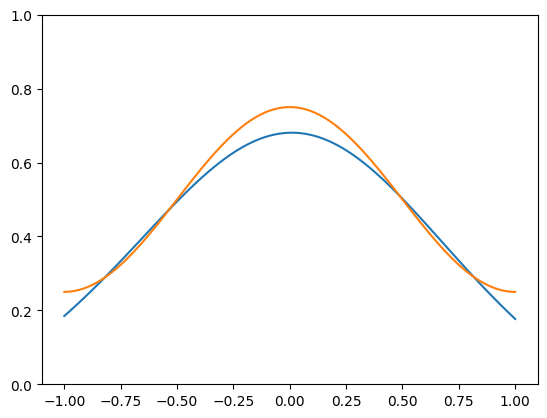

In [ ]:
plt.plot(X1_grid, p_y_g_x1)
plt.plot(X1_grid, p_y_g_x1_gt)
plt.ylim([0, 1])

(0.0, 1.0)

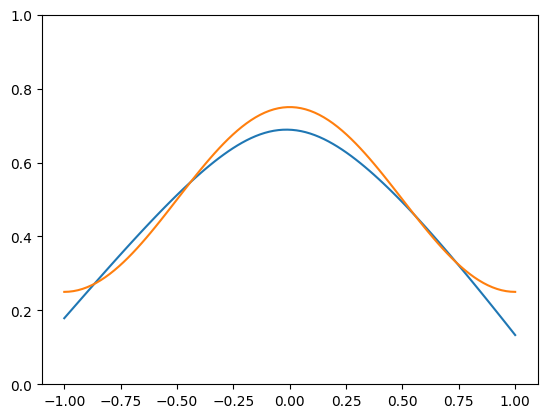

In [ ]:
plt.plot(X2_grid, p_y_g_x2)
plt.plot(X2_grid, p_y_g_x2_gt)
plt.ylim([0, 1])